## Description
* Pregnancies:Number of times pregnant
* GlucosePlasma glucose concentration a 2 hours in an oral glucose tolerance test
* BloodPressureDiastolic blood pressure (mm Hg)
* SkinThicknessTriceps skin fold thickness (mm)
* InsulinHour serum insulin (mu U/ml)
* BMIBody mass index (weight in kg/(height in m)^2)
* DiabetesPedigreeFunction As per https://www.personal.kent.edu/~mshanker/personal/Zip_files/sar_2000.pdf It utilizes information from a person’s family history to predict how diabetes will affect that individual
* AgeAge (years)
* OutcomeClass variable (0 or 1)

# Import

In [ ]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from plotly.offline import init_notebook_mode, iplot
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, precision_score, recall_score
from sklearn.metrics import accuracy_score, roc_auc_score,confusion_matrix

# Load data

In [ ]:
df = pd.read_csv('diabetes.csv')

In [ ]:
df.sample(15)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
585,1,93,56,11,0,22.5,0.417,22,0
1931,3,171,72,33,135,33.3,0.199,24,1
1656,9,72,78,25,0,31.6,0.280,38,0
906,12,140,85,33,0,37.4,0.244,41,0
172,2,87,0,23,0,28.9,0.773,25,0
806,0,117,0,0,0,33.8,0.932,44,0
1928,4,144,58,28,140,29.5,0.287,37,0
919,0,120,74,18,63,30.5,0.285,26,0
712,10,129,62,36,0,41.2,0.441,38,1
424,8,151,78,32,210,42.9,0.516,36,1


# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2000 non-null   int64  
 1   Glucose                   2000 non-null   int64  
 2   BloodPressure             2000 non-null   int64  
 3   SkinThickness             2000 non-null   int64  
 4   Insulin                   2000 non-null   int64  
 5   BMI                       2000 non-null   float64
 6   DiabetesPedigreeFunction  2000 non-null   float64
 7   Age                       2000 non-null   int64  
 8   Outcome                   2000 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 140.8 KB


In [ ]:
cdf = df.copy()

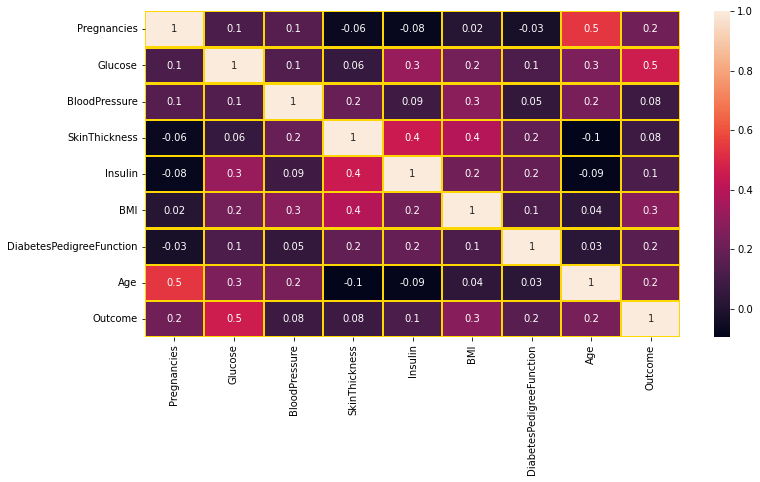

In [ ]:
plt.figure(figsize = (12,6)) 
sns.heatmap(cdf.corr(),robust=True,fmt='.1g',linewidths=1.3,linecolor = 'gold', annot=True,);

In [ ]:
cdf.nunique()

Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                53
Insulin                     182
BMI                         247
DiabetesPedigreeFunction    505
Age                          52
Outcome                       2
dtype: int64

In [ ]:
cdf.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,2000.0,3.70350,3.306063,0.000,1.000,3.000,6.000,17.00
Glucose,2000.0,121.18250,32.068636,0.000,99.000,117.000,141.000,199.00
BloodPressure,2000.0,69.14550,19.188315,0.000,63.500,72.000,80.000,122.00
SkinThickness,2000.0,20.93500,16.103243,0.000,0.000,23.000,32.000,110.00
Insulin,2000.0,80.25400,111.180534,0.000,0.000,40.000,130.000,744.00
BMI,2000.0,32.19300,8.149901,0.000,27.375,32.300,36.800,80.60
DiabetesPedigreeFunction,2000.0,0.47093,0.323553,0.078,0.244,0.376,0.624,2.42
Age,2000.0,33.09050,11.786423,21.000,24.000,29.000,40.000,81.00
Outcome,2000.0,0.34200,0.474498,0.000,0.000,0.000,1.000,1.00


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



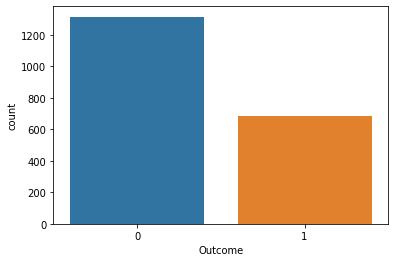

In [ ]:
sns.countplot(cdf.Outcome);

# Missing data

In [ ]:
def get_null_df(features:pd.DataFrame) -> pd.DataFrame:
    col_null_df = pd.DataFrame(columns = ['Feature', 'Type', 'Total NaN', 'Missing %'])
    col_null = features.columns[features.isna().any()].to_list()
    for col in col_null:
        dtype = "Numerical" if is_numeric_dtype(features[col]) else "Categorical"
        nulls = len(features[features[col].isna() == True][col])   
        col_null_df = col_null_df.append({'Feature': col, 
                                          'Type': dtype,
                                          'Total NaN': nulls,
                                          'Missing %': (nulls / len(features))*100
                                         }, ignore_index=True)
    return col_null_df

In [ ]:
get_null_df(cdf)

,Feature,Type,Total NaN,Missing %


# Train-test splitting

In [ ]:
X = cdf.drop(["Outcome"],axis = 1)

In [ ]:
y = cdf.Outcome

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 42)
cols = X.columns

# Simple Pipeline

In [ ]:
numerical_transformer =  Pipeline(steps=[
    ('norm', StandardScaler()),
    ])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, cols),
    ])

# Model selection

## 1) LogisticRegression

In [ ]:
model = LogisticRegression(solver='liblinear')

In [ ]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

In [ ]:
params = {'model__C': np.linspace(0.1, 5, 20), 
          'model__max_iter': [50, 100, 150, 200],
          'model__penalty': ('l1', 'l2')
         }

grid_search = GridSearchCV(clf, params, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
model_log = grid_search.best_estimator_ 

In [ ]:
model_log

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('norm',
                                                                   StandardScaler())]),
                                                  Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object'))])),
                ('model',
                 LogisticRegression(C=0.35789473684210527, max_iter=50,
                                    solver='liblinear'))])

In [ ]:
def roc_auc_plot(clf, X, y):
  y_pred_proba = clf.predict_proba(X)[:, 1]
  [fpr, tpr, thr] = roc_curve(y, y_pred_proba)
  idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

  plt.figure()
  plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
  plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
  plt.ylabel('True Positive Rate (recall)', fontsize=14)
  plt.title('Receiver operating characteristic (ROC) curve')
  plt.legend(loc="lower right")
  plt.show()
  print(f'precision_score = {precision_score(y, clf.predict(X))}')
  print(f'recall_score = {recall_score(y, clf.predict(X))}')

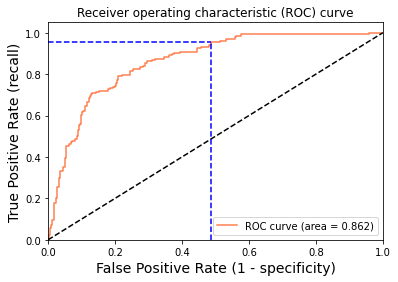

precision_score = 0.7547169811320755
recall_score = 0.6


In [ ]:
roc_auc_plot(model_log, X_test, y_test)

In [ ]:
accuracy_score(y_test, model_log.predict(X_test))

0.8016666666666666

In [ ]:
confusion_matrix(y_test, model_log.predict(X_test))

array([[361,  39],
       [ 80, 120]])

* ## 2) Random Forest

In [ ]:
model = RandomForestClassifier()

In [ ]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

In [ ]:
params = {'model__bootstrap': [True, False],
 'model__max_depth': [10, 20, 30, 40, 50, 60, 70],
 'model__max_features': ['auto', 'sqrt'],
 'model__min_samples_leaf': [1, 2, 4],
 'model__min_samples_split': [2, 5, 10],
 'model__n_estimators': [200, 400]}

grid_search = GridSearchCV(clf, params, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
model_RandomF = grid_search.best_estimator_ 

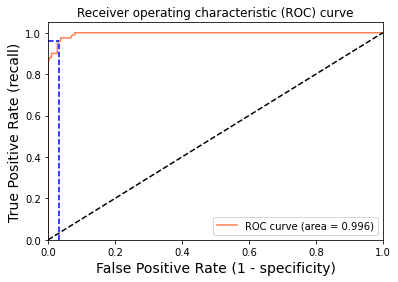

precision_score = 0.9432989690721649
recall_score = 0.915


In [ ]:
roc_auc_plot(model_RandomF, X_test, y_test)

In [ ]:
accuracy_score(y_test, model_RandomF.predict(X_test))

0.9533333333333334

In [ ]:
confusion_matrix(y_test, model_RandomF.predict(X_test))

array([[389,  11],
       [ 17, 183]])

In [ ]:
model_RandomF['model']

RandomForestClassifier(bootstrap=False, max_depth=70, max_features='sqrt',
                       n_estimators=200)

#### Importance

Text(0.5, 0, 'Değişken Önem Düzeyleri')

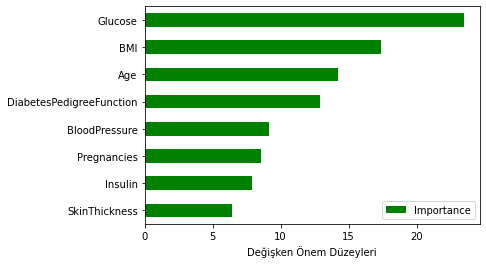

In [ ]:
Importance = pd.DataFrame({"Importance": model_RandomF['model'].feature_importances_*100},
                         index = X_train.columns)
Importance.sort_values(by = "Importance", 
                       axis = 0, 
                       ascending = True).plot(kind ="barh", color = "g")

plt.xlabel("Değişken Önem Düzeyleri")

## 2) KNN model

In [ ]:
model = KNeighborsClassifier()
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

In [ ]:
params = {"model__n_neighbors" : np.arange(1,50)}
grid_search = GridSearchCV(clf, params, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
modelKNN = grid_search.best_estimator_ 

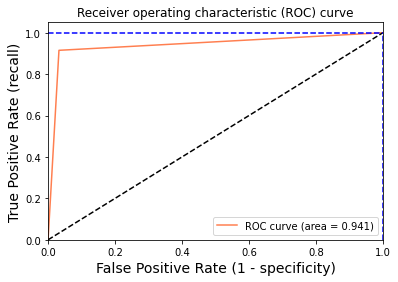

precision_score = 0.9336734693877551
recall_score = 0.915


In [ ]:
roc_auc_plot(modelKNN, X_test, y_test)

In [ ]:
accuracy_score(y_test, modelKNN.predict(X_test))

0.95

In [ ]:
confusion_matrix(y_test, modelKNN.predict(X_test))

array([[387,  13],
       [ 17, 183]])

## 3) GradientBoostingClassifier

In [ ]:
model = GradientBoostingClassifier()

In [ ]:
modelGBC = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])
modelGBC.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('norm',
                                                                   StandardScaler())]),
                                                  Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object'))])),
                ('model', GradientBoostingClassifier())])

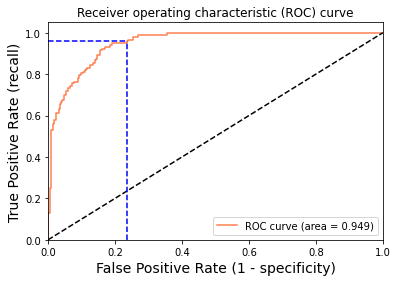

precision_score = 0.8514285714285714
recall_score = 0.745


In [ ]:
roc_auc_plot(modelGBC, X_test, y_test)

In [ ]:
accuracy_score(y_test, modelGBC.predict(X_test))


0.8716666666666667

In [ ]:
confusion_matrix(y_test, modelGBC.predict(X_test))

array([[374,  26],
       [ 51, 149]])

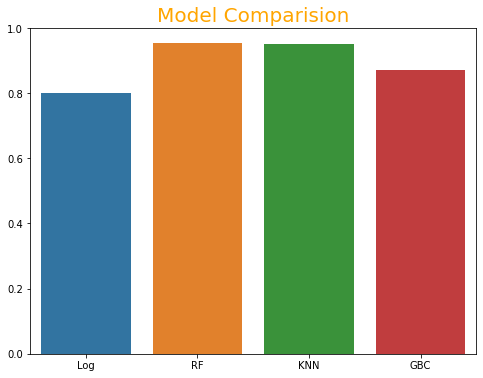

In [ ]:
indexx = ["Log", "RF", "KNN", "GBC"]
scores = [accuracy_score(y_test, ml.predict(X_test)) for ml in [model_log, model_RandomF, modelKNN, modelGBC]]

plt.figure(figsize=(8,6))
sns.barplot(x=indexx,y=scores)
plt.xticks()
plt.title('Model Comparision',color = 'orange',fontsize=20);


# Save model

In [ ]:
model_file = open("model_rf.pkl","wb")
pickle.dump(model_RandomF ,model_file)
model_file.close()

In [ ]:
model_file = open("model_log.pkl","wb")
pickle.dump(model_log ,model_file)
model_file.close()